In [20]:
# I'm sick of having to dowload and proccess them every time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import lightkurve as lk
from scipy.optimize import curve_fit


In [21]:
def stitch(lc_collection): 

    tot_time = np.zeros(0) # to store concatenated arrays
    tot_flux = np.zeros(0)
    tot_flux_err = np.zeros(0)
    tot_qual = np.zeros(0)
    for i in range(len(lc_collection)):
        lc = lc_collection[i]
        flux = lc.flux.value
        time = lc.time.value
        flux_err = lc.flux_err.value
        qual = lc.quality
        rel_flux_err = flux_err/flux
        nan_mask = np.invert(np.isnan(flux))
        
        # Fit and remove linear trend
        popt, pcov = curve_fit(linear_func, time[nan_mask], flux[nan_mask])
        linear_trend = linear_func(time, *popt) # evaluate over the whole interval
        norm = flux / linear_trend
        
        tot_time = np.hstack([tot_time, time])
        tot_flux = np.hstack([tot_flux, norm])
        tot_flux_err = np.hstack([tot_flux_err, rel_flux_err])
        tot_qual = np.hstack([tot_qual, qual])
        
    return tot_time, tot_flux, tot_flux_err, tot_qual

# remove trends in baseline flux data
def linear_func(x, a, b):
  return a*x + b

In [22]:
#kep_names = open('flagged_planets_unique.txt', "r").read().split(', ') #open('planet_list_228_updated_5-30-22.txt', "r").read().split(', ')
#kep_names += open('system_planets_6-4-22.txt', "r").read().split(', ')
kep_names =  ['Kepler-51 b', 'Kepler-1655 b', 'Kepler-314 c', 'Kepler-422 b', 'Kepler-41 b', 'Kepler-433 b', 'Kepler-682 b', 'Kepler-685 b', 'Kepler-74 b' ] #open(infile, "r").read().split(', ')
out = 'Stitched_Lightcurves'

# search for and download all lightcurves
for i in range(len(kep_names[1:])):
    planet_name =  kep_names[i]

    if planet_name.startswith('kepler-') or planet_name.startswith('Kepler-'):
        planet_name = planet_name.replace('k','K')
        star_name = planet_name[:-1].replace(' ', '')
        obs_type = planet_name.split('-')[0]
        
    search_result = lk.search_lightcurve(star_name, author=obs_type, cadence='long')
    lc_collection = search_result.download_all()
    lc = lc_collection.stitch() #.remove_outliers() # it turns out removing outliers can remove transits as well! As can flattening with a poor window choice. 
    time, flux, flux_err, quality = stitch(lc_collection)
    
    arr = np.hstack([time.reshape(-1,1), flux.reshape(-1,1), flux_err.reshape(-1,1), quality.reshape(-1,1)])
    
    df = pd.DataFrame(arr, columns = ['time', 'flux', 'flux_err', 'quality'])
    #df.to_csv(out + '/' + planet_name + '.csv', index = False)
    

/home/azuckerman/.local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/azuckerman/.local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


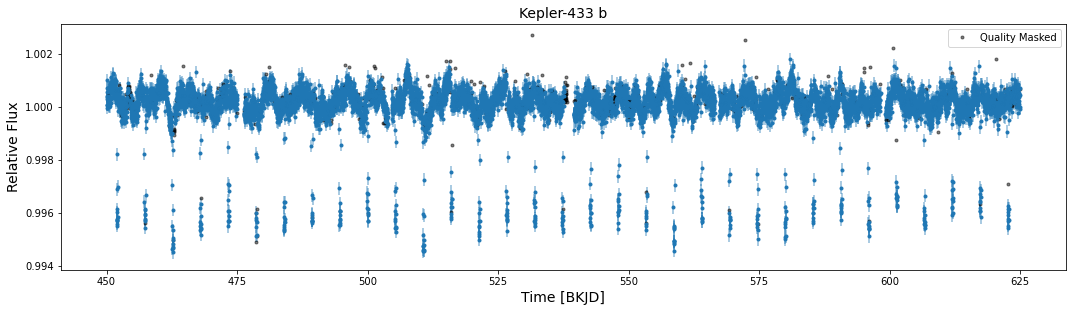

In [187]:
# plot some up to put one as an example in the paper
names = ['Kepler-433 b'] #['Kepler-6 b', 'Kepler-1515 b']
fig = plt.figure(figsize = [15,8])
for i in range(len(names)):
    planet_name =  names[i]
    lc = pd.read_csv(out + '/' + planet_name + '.csv')
    time = lc['time']
    flux = lc['flux']
    flux_err = lc['flux_err']
    quality = lc['quality']
    
    # their way:
    search_result = lk.search_lightcurve(star_name, author=obs_type, cadence='long')
    lc_collection = search_result.download_all()
    lk_lc = lc_collection.stitch().remove_outliers()
    lk_flux = lk_lc.flux.value
    lk_time = lk_lc.time.value
    lk_flux_err = lk_lc.flux_err.value
    lk_quality = lk_lc.quality.value
    
    # 
    start = 450
    stop = 625 #time.iloc[-1]
    interval = (time >= start) * (time <= stop)
    time = time[interval]
    flux = flux[interval]
    flux_err = flux_err[interval]
    quality = quality[interval]
    lk_interval = (lk_time >= start) * (lk_time <= stop)
    lk_time = lk_time[lk_interval]
    lk_flux = lk_flux[lk_interval]
    lk_flux_err = lk_flux_err[lk_interval]
    lk_quality = lk_quality[lk_interval]
    
    quality_cut = (quality == 0) 
    good_data_flag = quality_cut * (flux_err > 0) * (np.isfinite(time)) * (np.isfinite(flux)) * (np.isfinite(flux_err))  
    lk_quality_cut = (lk_quality == 0) 
    lk_good_data_flag = lk_quality_cut * (lk_flux_err > 0) * (np.isfinite(lk_time)) * (np.isfinite(lk_flux)) * (np.isfinite(lk_flux_err))
    #time_no_cut = np.copy(time)
    #flux_no_cut = np.copy(flux)
    #time = time[good_data_flag]
    #flux = flux[good_data_flag]
    #flux_err = flux_err[good_data_flag]
    
    fs = 14
    plt.subplot(2,1,i+1)
    plt.plot(time[np.invert(good_data_flag)], flux[np.invert(good_data_flag)], '.', color = 'k', alpha = 0.5, label = 'Quality Masked')
    plt.plot(time[good_data_flag], flux[good_data_flag], '.', color = 'C0')#, alpha = 0.5)#, label = 'my stitching')
    plt.errorbar(time[good_data_flag], flux[good_data_flag], yerr = flux_err[good_data_flag], ls = 'None', color = 'C0', alpha = 0.5)
    
    #plt.plot(lk_time[np.invert(lk_good_data_flag)], lk_flux[np.invert(lk_good_data_flag)], '.', color = 'red', alpha = 0.5, label = 'Quality Masked')
    #plt.plot(lk_time[lk_good_data_flag], lk_flux[lk_good_data_flag], '.-', color = 'C2', alpha = 0.5)
    #plt.errorbar(lk_time[lk_good_data_flag], lk_flux[lk_good_data_flag], yerr = lk_flux_err[lk_good_data_flag], ls = 'None', color = 'C2', alpha = 0.5, label = 'lk stitching')
    
    #plt.xlim([500,600])
    plt.title(planet_name, fontsize = fs)
    plt.xlabel('Time [BKJD]', fontsize = fs)
    plt.ylabel('Relative Flux', fontsize = fs)
    plt.legend(fontsize = fs - 4)
fig.tight_layout()

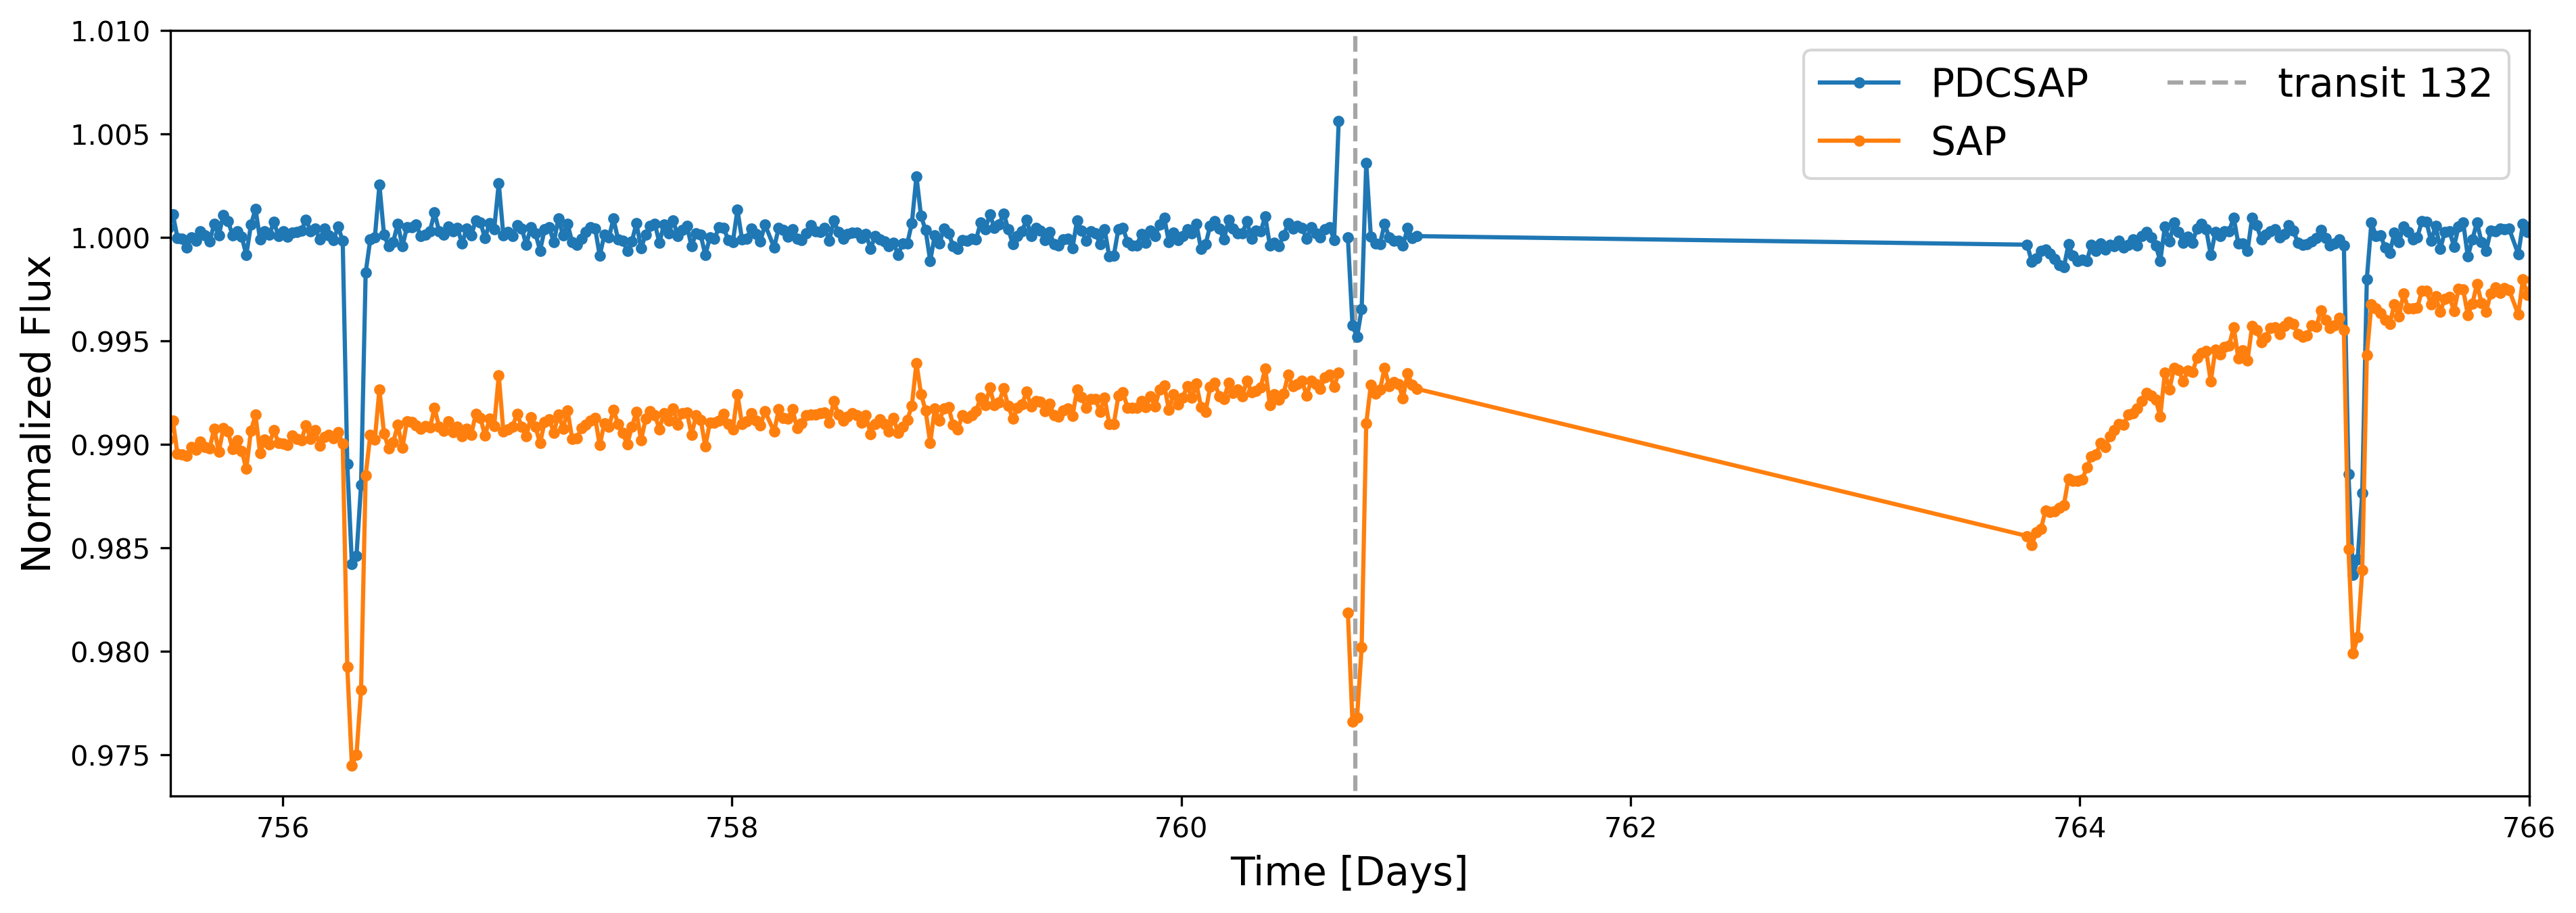

In [155]:
#testing
planet_name =  'Kepler-548 b'

if planet_name.startswith('kepler-') or planet_name.startswith('Kepler-'):
    planet_name = planet_name.replace('k','K')
    star_name = planet_name[:-1].replace(' ', '')
    obs_type = planet_name.split('-')[0]

plt.figure(figsize = [15,5], dpi = 300)
search_result = lk.search_lightcurve(star_name, author=obs_type, cadence='long')
lc_collection = search_result.download_all()
fs = 14
#lc_collection.stitch().time.value
for i in [7]:#range(len(lc_collection)):
    lc = lc_collection[i]
    #lc.plot()
    flux = lc.flux.value # default is pdcsap flux
    sap_flux = lc['sap_flux']
    time = lc.time.value
    flux_err = lc.flux_err.value
    
    start = time[0]
    stop = time[-1]
    interval = (time >= start) * (time <= stop)
    time = time[interval]
    flux = flux[interval]
    flux_err = flux_err[interval]
    plt.plot(time, flux/np.nanmedian(flux), '.-', label = 'PDCSAP') #, no stitching, quality masking or outlier removal')
    plt.plot(time, sap_flux/np.nanmedian(sap_flux), '.-', label = 'SAP') #, no stitching, quality masking or outlier removal')
    plt.xlabel('Time [Days]', fontsize = fs)
    plt.ylabel('Normalized Flux', fontsize = fs)
    #plt.xlim([700,800])
    plt.ylim([0.973, 1.010]); plt.xlim([755.5,766])
    plt.vlines([760.775], ls = 'dashed', ymin = 0.97, ymax = 1.015, alpha = 0.35, label = 'transit 132')
    plt.legend(fontsize = fs, ncol = 2)#, loc = 'lower right')
    #quality = quality[interval]
    

In [101]:
star = 'Kepler-51'
lc_collection = lk.search_lightcurve(star, author=obs_type, cadence='long').download_all()
for lc in lc_collection:
    print(lc.time.value)

[131.51170833 131.53214275 131.55257707 ... 164.94219515 164.96262927
 164.98306349]
[169.76465881 169.7850931  169.80552719 ... 258.42670817 258.44714142
 258.46757477]
[260.22483296 260.24526629 260.26569951 ... 349.45548811 349.47592104
 349.49635397]
[352.37739799 352.39783094 352.43869684 ... 442.16192809 442.18236207
 442.20279595]
[443.49013729 443.51057139 443.53100529 ... 538.10065216 538.12108646
 538.16195477]
[539.46972458 539.49015878 539.51059307 ... 629.2352287  629.25566206
 629.29652846]
[630.17515822 630.19559156 630.21602481 ... 719.48759831 719.50803133
 719.54889717]
[735.36400629 735.38443934 735.40487238 ... 802.30393351 802.32436726
 802.34480121]
[808.51582266 808.53625658 808.5566905  ... 905.88488936 905.90532349
 905.92575782]
[ 906.84526551  906.86569983  906.88613406 ... 1000.227695   1000.24812826
 1000.26856143]
[1001.20846156 1001.22889472 1001.24932807 ... 1098.28541522 1098.30584828
 1098.32628115]
[1099.40922157 1099.42965465 1099.45008762 ... 1181.9

In [157]:
np.shape(flux)


(3113,)